In [3]:
import os
import sys
import random
import warnings
import shutil

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from numpy import pad
from skimage.util import crop
from skimage.measure import label 
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

In [4]:
len(os.listdir('/kaggle/working/train/images'))

6000

In [5]:
import os
import random
import shutil

# Đường dẫn đến thư mục chứa toàn bộ ảnh
source_dir = '/kaggle/input/landscape-image-colorization/landscape Images/color'

# Đường dẫn đến thư mục đích để lưu trữ 7000 ảnh mẫu
destination_dir = '/kaggle/working/train/images'

# Số lượng ảnh cần chọn
num_images_to_select = 6000
# Lấy danh sách tất cả các tệp ảnh trong thư mục nguồn
all_images = os.listdir(source_dir)

# Kiểm tra số lượng ảnh có sẵn
num_images_available = len(all_images)

# In ra số lượng ảnh có sẵn để kiểm tra
print(f"Số lượng ảnh có sẵn: {num_images_available}")

# Đảm bảo rằng chúng ta không chọn nhiều hơn số lượng ảnh có sẵn
if num_images_to_select > num_images_available:
    raise ValueError("Số lượng ảnh cần chọn lớn hơn số lượng ảnh có sẵn")

# Chọn ngẫu nhiên 7000 ảnh từ danh sách
sampled_images = random.sample(all_images, num_images_to_select)

# Tạo thư mục đích nếu nó chưa tồn tại
os.makedirs(destination_dir, exist_ok=True)

# Sao chép các ảnh được chọn vào thư mục đích
for image in sampled_images:
    source_path = os.path.join(source_dir, image)
    destination_path = os.path.join(destination_dir, image)
    shutil.copy(source_path, destination_path)

print(f"Đã sao chép {num_images_to_select} ảnh vào {destination_dir}")


Số lượng ảnh có sẵn: 7129
Đã sao chép 6000 ảnh vào /kaggle/working/train/images


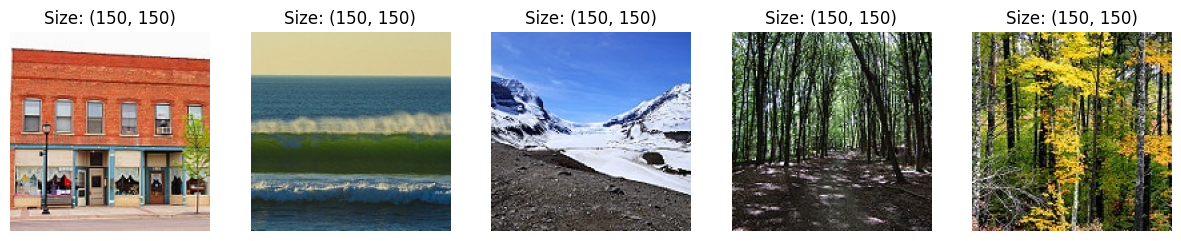

In [4]:
import matplotlib.pyplot as plt

# Hiển thị một số ảnh mẫu cùng với kích thước của chúng
def visualize_images(image_paths, num_images=5):
    plt.figure(figsize=(15, 15))
    for i, image_path in enumerate(image_paths[:num_images]):
        img = Image.open(image_path)
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Size: {img.size}")
        plt.axis('off')
    plt.show()

# Đường dẫn đầy đủ đến các ảnh đã sao chép
sampled_image_paths = [os.path.join(destination_dir, img) for img in sampled_images]

# Trực quan hóa 5 ảnh đầu tiên
visualize_images(sampled_image_paths, num_images=5)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2024-06-16 04:11:46.444228: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 04:11:46.444361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 04:11:46.633438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:

train_datagen = ImageDataGenerator(rescale = 1/255,
                                   featurewise_center = False,
                                   rotation_range = 20,
                                   horizontal_flip = False)

In [30]:
train = train_datagen.flow_from_directory("/kaggle/working/train", 
                                          target_size = (256,256), 
                                          batch_size = 500, 
                                          shuffle = True)

Found 7000 images belonging to 1 classes.


In [ ]:
#giới hạn huấn luuyen

In [31]:
t_img, label = next(train)


In [32]:
def plot_img(img_arr, label):
    
    plt.figure(figsize=(5,5))
    for img, l in zip(img_arr, label):
        plt.imshow(img)
        plt.title(img.shape)
        plt.axis('off')
        plt.show()
    

In [33]:
t_img.shape

(500, 256, 256, 3)

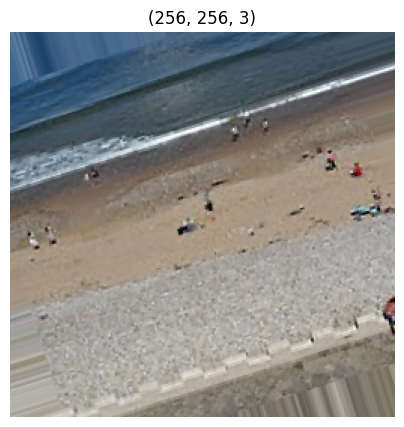

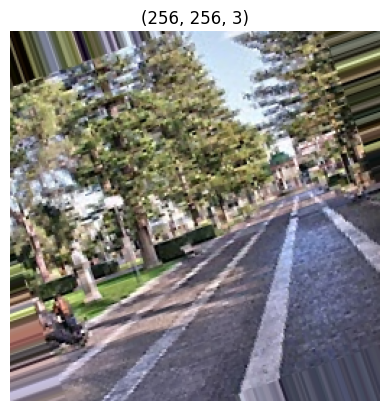

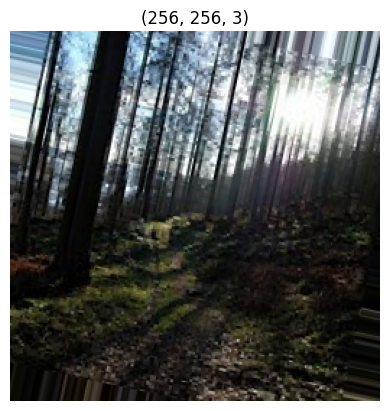

In [34]:
plot_img(t_img[:3],label)

In [35]:
X = []

In [36]:
y = []

In [37]:
for img in t_img:
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0])
        y.append(lab[:,:,1:]/128)
        
    except:
        print("error")


In [38]:
x_train = np.array(X)
x_train = np.expand_dims(x_train, axis = len(x_train.shape))
y_train = np.array(y)

In [39]:
x_train.shape, y_train.shape

((500, 256, 256, 1), (500, 256, 256, 2))

In [40]:
from sklearn.model_selection import train_test_split

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra với tỷ lệ 80-20
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# In ra kích thước của tập huấn luyện và tập kiểm tra
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)k


Shape of x_train: (400, 256, 256, 1)
Shape of y_train: (400, 256, 256, 2)
Shape of x_test: (100, 256, 256, 1)
Shape of y_test: (100, 256, 256, 2)


In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, UpSampling2D, LeakyReLU, BatchNormalization, Add
from keras.regularizers import l2

model = Sequential()
#encoder

# Lớp tích chập đầu tiên: trích xuất đặc trưng từ ảnh đầu vào
model.add(Conv2D(64, (3,3), activation='relu', padding='same', strides=2, input_shape=(256,256,1)))
model.add(BatchNormalization())

# Lớp tích chập thứ hai
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Lớp tích chập thứ ba: giảm kích thước không gian
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())

# Lớp tích chập thứ tư
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Lớp tích chập thứ năm: giảm kích thước không gian
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())

# Lớp tích chập thứ sáu
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Lớp tích chập thứ bảy
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Lớp tích chập cuối cùng trong phần encoder
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())


# Decoder
# Lớp tích chập đầu tiên trong phần decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Lớp UpSampling2D: tăng kích thước không gian
model.add(UpSampling2D((2, 2)))

# Lớp tích chập thứ hai trong phần decoder
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Lớp UpSampling2D thứ hai
model.add(UpSampling2D((2, 2)))

# Lớp tích chập thứ ba trong phần decoder
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Lớp tích chập thứ tư trong phần decoder
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Lớp tích chập cuối cùng: tái tạo ảnh màu
model.add(Conv2D(2, (3,3), activation='tanh', padding='same'))

# Lớp UpSampling2D cuối cùng: tăng kích thước không gian về kích thước ban đầu
model.add(UpSampling2D((2, 2)))


model.summary()

2024-06-17 06:55:42.324343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 06:55:42.324505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 06:55:42.478623: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,228,818 (23.76 MB)

 Trainable params: 6,224,114 (23.74 MB)

 Non-trainable params: 4,704 (18.38 KB)

In [48]:
import tensorflow as tf

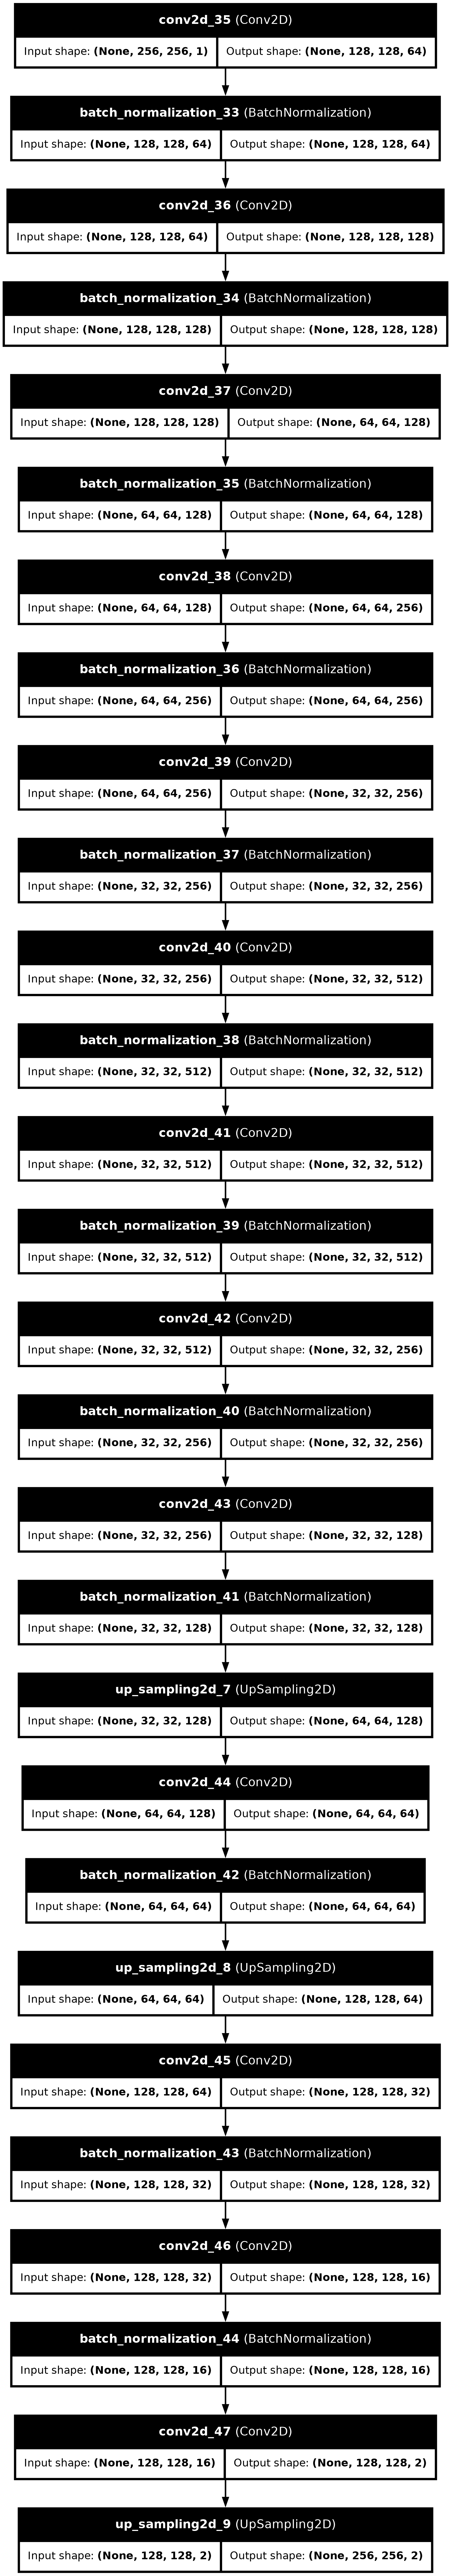

In [78]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [83]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss='mse',
              metrics=['acc'])

In [84]:
# Tiếp tục huấn luyện mô hình trên tập huấn luyện
history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 283s 21s/step - acc: 0.6683 - loss: 0.0081
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 322s 21s/step - acc: 0.6666 - loss: 0.0079
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 272s 21s/step - acc: 0.6762 - loss: 0.0084
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 272s 21s/step - acc: 0.6812 - loss: 0.0075
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 273s 21s/step - acc: 0.6696 - loss: 0.0083
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 273s 21s/step - acc: 0.6710 - loss: 0.0075
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 272s 21s/step - acc: 0.6674 - loss: 0.0076
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 273s 21s/step - acc: 0.6816 - loss: 0.0087
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 322s 21s/step - acc: 0.6675 - loss: 0.0078
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 272s 21s/step - acc: 0.6854 - loss: 0.0083
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 274s 21s/step - acc: 0.6726 - loss: 0.0079
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 275s 21s/step - acc: 0.6799 - loss: 0.0078
Epoch 13/50
13/13 ━━━━━━━

In [94]:
model.save('colorize_image012.h5')

#  **ĐÁNH GIÁ**

In [85]:
# Đánh giá mô hình trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - acc: 0.6626 - loss: 0.0092
Test Loss: 0.008522897027432919
Test Accuracy: 0.6612852215766907


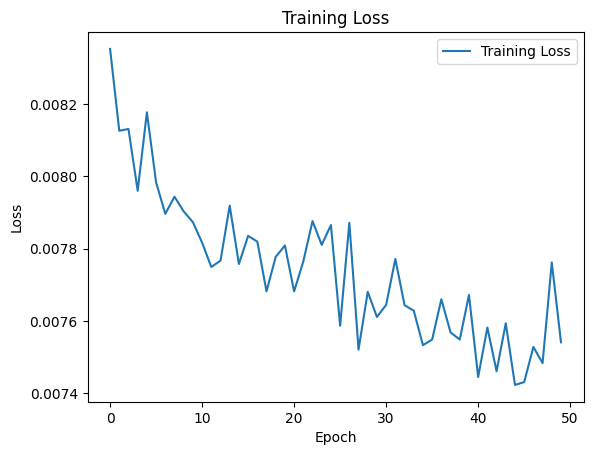

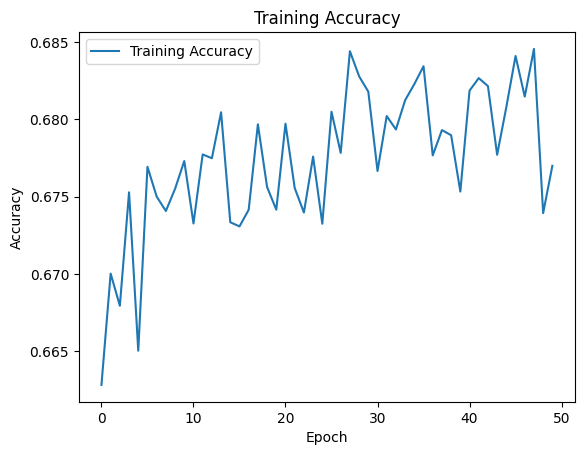

In [86]:
import matplotlib.pyplot as plt

# Lấy thông tin về mất mát và độ chính xác từ history
loss = history.history['loss']
accuracy = history.history['acc']

# Tạo biểu đồ về mất mát
plt.plot(loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Tạo biểu đồ về độ chính xác
plt.plot(accuracy, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Function to convert continuous predictions to discrete labels
def convert_to_labels(predictions):
    return np.argmax(predictions, axis=-1)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Generate predictions on the test set
y_pred = model.predict(x_test)

# Convert predictions to labels (assuming this is a multi-class problem)
y_pred_labels = convert_to_labels(y_pred)
y_test_labels = convert_to_labels(y_test)

# Flatten the arrays to compute classification metrics
y_pred_labels_flat = y_pred_labels.flatten()
y_test_labels_flat = y_test_labels.flatten()

# Calculate metrics
accuracy = accuracy_score(y_test_labels_flat, y_pred_labels_flat)
precision = precision_score(y_test_labels_flat, y_pred_labels_flat, average='weighted')
recall = recall_score(y_test_labels_flat, y_pred_labels_flat, average='weighted')
f1 = f1_score(y_test_labels_flat, y_pred_labels_flat, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Detailed classification report
report = classification_report(y_test_labels_flat, y_pred_labels_flat)
print("Classification Report:\n", report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - acc: 0.6626 - loss: 0.0092
Test Loss: 0.008522897027432919
Test Accuracy: 0.6612852215766907
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step
Accuracy: 0.6612852478027343
Precision: 0.664250246561404
Recall: 0.6612852478027343
F1-score: 0.6597858215262546
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.59      0.64   3279369
           1       0.64      0.73      0.68   3274231

    accuracy                           0.66   6553600
   macro avg       0.66      0.66      0.66   6553600
weighted avg       0.66      0.66      0.66   6553600



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

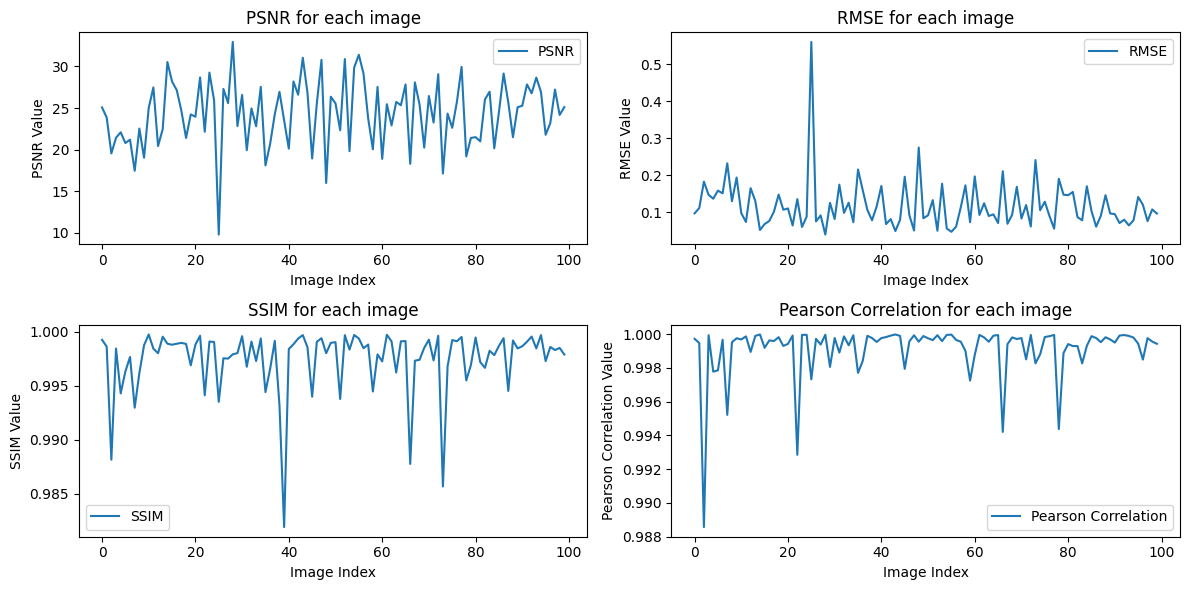

In [75]:
import numpy as np
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define MSE function
def mse(imageA, imageB):
    # Mean Squared Error
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

# Define function to calculate metrics
def calculate_metrics(original, generated):
    if original.shape[-1] == 3:
        # Convert images to grayscale for SSIM and Pearson correlation
        original_gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
        generated_gray = cv2.cvtColor(generated, cv2.COLOR_RGB2GRAY)
    else:
        original_gray = original  # Skip conversion if already in grayscale
        generated_gray = generated

    # PSNR
    psnr_value = psnr(original, generated, data_range=1.0)

    # RMSE
    rmse_value = np.sqrt(mse(original, generated))

    # SSIM
    ssim_value, _ = ssim(original_gray, generated_gray, data_range=1.0, full=True)

    # Pearson Correlation
    original_flat = original_gray.flatten()
    generated_flat = generated_gray.flatten()
    pearson_value, _ = pearsonr(original_flat, generated_flat)

    return psnr_value, rmse_value, ssim_value, pearson_value

# Assuming you have defined and trained your model already
# Evaluate the metrics on the test data
psnr_values = []
rmse_values = []
ssim_values = []
pearson_values = []

for i in range(len(x_test)):
    generated_ab = model.predict(np.expand_dims(x_test[i], axis=0))[0]
    generated_ab = generated_ab * 128
    generated_lab = np.concatenate((x_test[i], generated_ab), axis=-1)
    generated_rgb = cv2.cvtColor(generated_lab.astype("float32"), cv2.COLOR_LAB2RGB)

    original_lab = np.concatenate((x_test[i], y_test[i] * 128), axis=-1)
    original_rgb = cv2.cvtColor(original_lab.astype("float32"), cv2.COLOR_LAB2RGB)

    psnr_value, rmse_value, ssim_value, pearson_value = calculate_metrics(original_rgb, generated_rgb)
    psnr_values.append(psnr_value)
    rmse_values.append(rmse_value)
    ssim_values.append(ssim_value)
    pearson_values.append(pearson_value)

# Print average metrics
print(f"Average PSNR: {np.mean(psnr_values)}")
print(f"Average RMSE: {np.mean(rmse_values)}")
print(f"Average SSIM: {np.mean(ssim_values)}")
print(f"Average Pearson Correlation: {np.mean(pearson_values)}")

# Plotting the metrics
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(psnr_values, label='PSNR')
plt.xlabel('Image Index')
plt.ylabel('PSNR Value')
plt.title('PSNR for each image')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(rmse_values, label='RMSE')
plt.xlabel('Image Index')
plt.ylabel('RMSE Value')
plt.title('RMSE for each image')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(ssim_values, label='SSIM')
plt.xlabel('Image Index')
plt.ylabel('SSIM Value')
plt.title('SSIM for each image')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(pearson_values, label='Pearson Correlation')
plt.xlabel('Image Index')
plt.ylabel('Pearson Correlation Value')
plt.title('Pearson Correlation for each image')
plt.legend()

plt.tight_layout()
plt.show()


In [76]:
import time

# Đo thời gian thực thi của mô hình
start_time = time.time()
# Thực hiện dự đoán
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


Execution time: 3.2901763916015625e-05 seconds


test ảnh bên ngoai (ko có trong dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


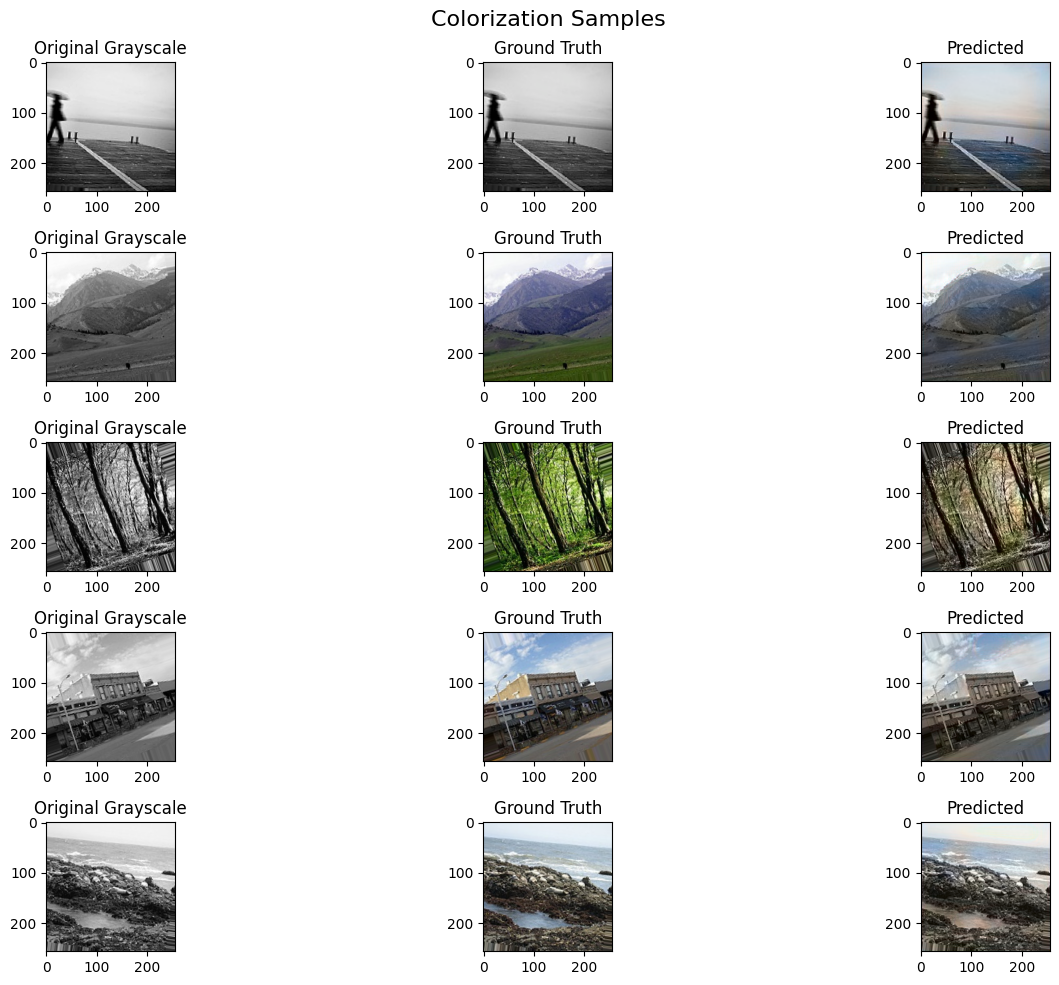

In [87]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_colorization_samples(x_test, y_test, model, num_samples=5):
    sample_indices = random.sample(range(len(x_test)), num_samples)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 10))
    fig.suptitle('Colorization Samples', fontsize=16)

    for i, idx in enumerate(sample_indices):
        original_gray = x_test[idx].reshape(256, 256)
        ground_truth_ab = y_test[idx] * 128
        original_lab = np.concatenate((x_test[idx], ground_truth_ab), axis=-1)
        original_rgb = cv2.cvtColor(original_lab.astype("float32"), cv2.COLOR_LAB2RGB)

        generated_ab = model.predict(np.expand_dims(x_test[idx], axis=0))[0] * 128
        generated_lab = np.concatenate((x_test[idx], generated_ab), axis=-1)
        generated_rgb = cv2.cvtColor(generated_lab.astype("float32"), cv2.COLOR_LAB2RGB)

        axes[i, 0].imshow(original_gray, cmap='gray')
        axes[i, 0].set_title('Original Grayscale')

        axes[i, 1].imshow(original_rgb)
        axes[i, 1].set_title('Ground Truth')

        axes[i, 2].imshow(generated_rgb)
        axes[i, 2].set_title('Predicted')

    plt.tight_layout()
    plt.show()

# Sử dụng hàm plot_colorization_samples
plot_colorization_samples(x_test, y_test, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


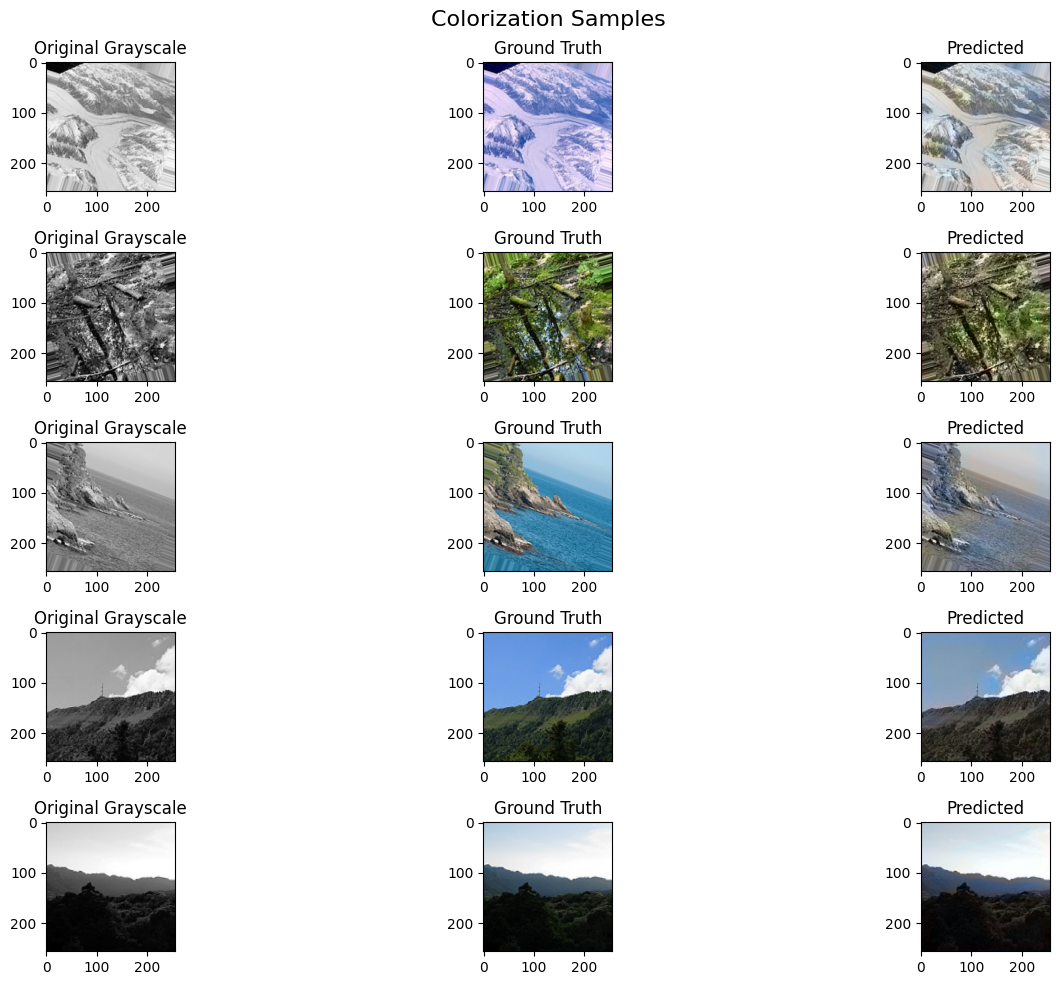

In [88]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_colorization_samples(x_test, y_test, model, num_samples=5):
    sample_indices = random.sample(range(len(x_test)), num_samples)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 10))
    fig.suptitle('Colorization Samples', fontsize=16)

    for i, idx in enumerate(sample_indices):
        original_gray = x_test[idx].reshape(256, 256)
        ground_truth_ab = y_test[idx] * 128
        original_lab = np.concatenate((x_test[idx], ground_truth_ab), axis=-1)
        original_rgb = cv2.cvtColor(original_lab.astype("float32"), cv2.COLOR_LAB2RGB)

        generated_ab = model.predict(np.expand_dims(x_test[idx], axis=0))[0] * 128
        generated_lab = np.concatenate((x_test[idx], generated_ab), axis=-1)
        generated_rgb = cv2.cvtColor(generated_lab.astype("float32"), cv2.COLOR_LAB2RGB)

        axes[i, 0].imshow(original_gray, cmap='gray')
        axes[i, 0].set_title('Original Grayscale')

        axes[i, 1].imshow(original_rgb)
        axes[i, 1].set_title('Ground Truth')

        axes[i, 2].imshow(generated_rgb)
        axes[i, 2].set_title('Predicted')

    plt.tight_layout()
    plt.show()

# Sử dụng hàm plot_colorization_samples
plot_colorization_samples(x_test, y_test, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


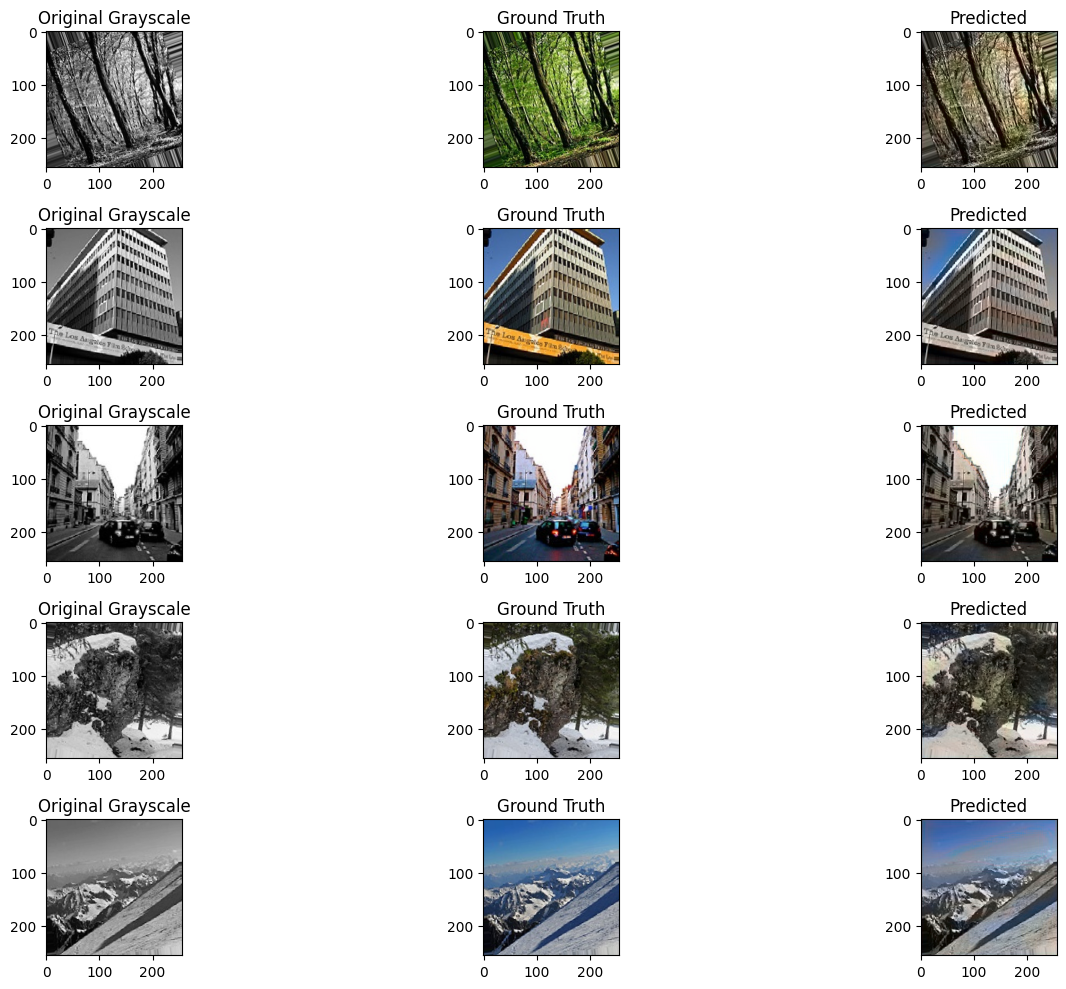

In [95]:
import random

# Select random samples from the test set
num_samples = 5
sample_indices = random.sample(range(len(x_test)), num_samples)

# Plot original grayscale, ground truth, and predicted colorized images
plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    # Original grayscale image
    original_gray = x_test[idx].reshape(256, 256)
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(original_gray, cmap='gray')
    plt.title('Original Grayscale')

    # Ground truth colorized image
    ground_truth_ab = y_test[idx] * 128
    original_lab = np.concatenate((x_test[idx], ground_truth_ab), axis=-1)
    original_rgb = cv2.cvtColor(original_lab.astype("float32"), cv2.COLOR_LAB2RGB)
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(original_rgb)
    plt.title('Ground Truth')

    # Predicted colorized image
    generated_ab = model.predict(np.expand_dims(x_test[idx], axis=0))[0] * 128
    generated_lab = np.concatenate((x_test[idx], generated_ab), axis=-1)
    generated_rgb = cv2.cvtColor(generated_lab.astype("float32"), cv2.COLOR_LAB2RGB)
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(generated_rgb)
    plt.title('Predicted')

plt.tight_layout()
plt.show()
